In [23]:
cd whitehead/

[Errno 2] No such file or directory: 'whitehead/'
/main/whitehead


/usr/local/lib/python3.10/site-packages/IPython/core/magics/osm.py:393: UserWarning: This is now an optional IPython functionality, using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})


In [24]:
import sys

sys.path.append('..')
import itertools
import pickle
from os import environ
from pathlib import Path
from uuid import uuid1

import numpy as np
import pandas as pd
import torch
import wandb
from ignite.contrib.handlers.tqdm_logger import ProgressBar
from ignite.engine import Engine, Events
from ignite.handlers.tensorboard_logger import *
from ignite.handlers.wandb_logger import *
from ignite.metrics import Accuracy
from lming.utils import download_artifact
from schedulefree import AdamWScheduleFree, SGDScheduleFree
from sklearn.model_selection import train_test_split
from tokenizer import build_tokenizer
from torch.optim import SGD, AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from transformers import AutoModelForSequenceClassification, BertConfig

### PREPARE MODEL

In [25]:
tokenizer = build_tokenizer('word-level', fdim=3, add_commutator_tokens=True,
                            add_prompt_tokens=True, add_post_processor=True)

config = BertConfig(
    vocab_size = len(tokenizer.get_vocab()),
    hidden_size = 768,
    num_hidden_layers = 8,
    num_attention_heads = 6,
    intermediate_size = 512,
    num_labels=2,
    bos_token_id = tokenizer.bos_token_id,
    eos_token_id = tokenizer.eos_token_id,
    pad_token_id = tokenizer.pad_token_id,
)

/usr/local/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


### PREPARE DATA

In [26]:
environ['WANDB_USERNAME']='pavel-tikhomirov'
environ['WANDB_DIR']=f'/main/whitehead/{environ["WANDB_USERNAME"]}-runs/'
environ['TOKENIZERS_PARALLELISM']='false'

run = wandb.init(entity='ml-in-algebraic-topology', project='whitehead')
artifact_dir = download_artifact('fdim-3-whitehead:v4')

wandb.finish()

loss/train/output,▄▂▆▄▇█▄▆▅▄▇▃▂▃▅▃▃▄▂▄▆▆▁█▆▅▃▆▂▄▃▁▃▄▄▂▄▁▃▁
loss/train/output,0.70352


wandb: Downloading large artifact fdim-3-whitehead:v4, 167.68MB. 3 files... 
wandb:   3 of 3 files downloaded.  
Done. 0:0:0.5


In [27]:
with open(Path(artifact_dir) / "train.pkl", 'rb') as f:
    train_data = pickle.load(f)
with open(Path(artifact_dir) / "val.pkl", 'rb') as f:
    val_data = pickle.load(f)

data = train_data + val_data

def process_word(word):
    return {
        'word_str': word['word_str'].split(':')[1],
        'label': int(word['label'] == 'c'),
        'len': len(word['word_str'].split(':')[1].split())
        }

data_processed = list(map(process_word, tqdm(data)))

100%|████████████████████████████████████████████████████████████████████| 800000/800000 [00:03<00:00, 247885.25it/s]


In [28]:
train_data_processed = list(map(process_word, tqdm(train_data)))
val_data_processed = list(map(process_word, tqdm(val_data)))

100%|████████████████████████████████████████████████████████████████████| 600844/600844 [00:02<00:00, 264816.32it/s]


In [29]:
df = pd.DataFrame(data_processed)
df_train = pd.DataFrame(train_data_processed)
df_val = pd.DataFrame(val_data_processed)

In [30]:
min_com_length = df[['label', 'len']].groupby('label').min().loc[1].item()
max_common_length = df[['label', 'len']].groupby('label').max().min().item()

In [31]:
MAX_LEN_THRESHOLD = 90
test_no_com_small_length = df[df.len < min_com_length]
df_main = df_train[df_train.len <= MAX_LEN_THRESHOLD]
test_big_length = df_train[df_train.len > MAX_LEN_THRESHOLD]
test_only_com = df_val[df_val.len > max_common_length]

In [66]:
train, val = train_test_split(df_main, stratify=df_main.label, test_size=0.1)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# sns.histplot(test_no_com_small_length.len)
# sns.histplot(test_only_com)


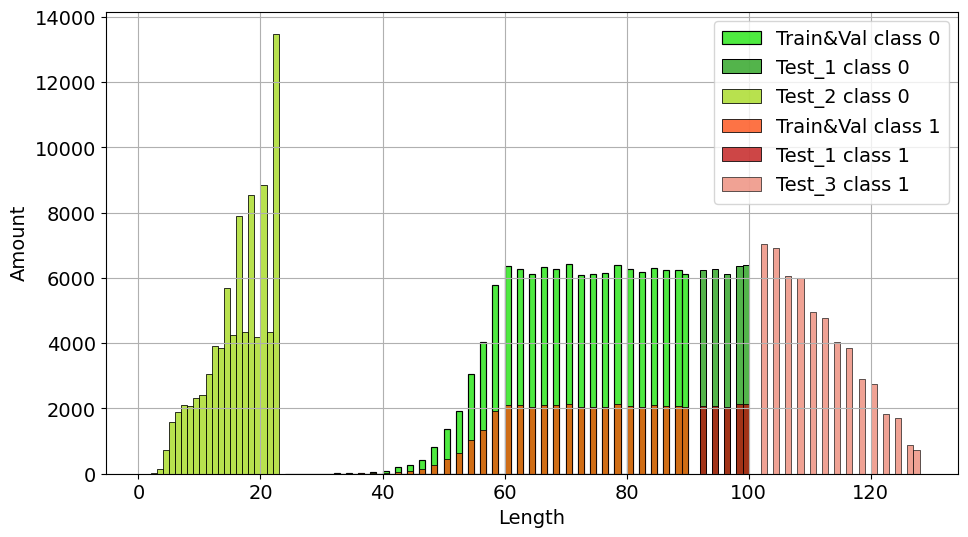

In [98]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define the number of bins
bins = 1

plt.figure(figsize=(11, 6))

# Plotting with the specified number of bins
sns.histplot(df_main[df_main.label == 0].len, binwidth=bins, color="#12e300", label='Train&Val class 0')

sns.histplot(test_big_length[test_big_length.label == 0].len, binwidth=bins, color="#1a9b0f", label='Test_1 class 0')
sns.histplot(test_no_com_small_length.len, binwidth=bins, color="#a0d812", label='Test_2 class 0')
sns.histplot(df_main[df_main.label == 1].len, binwidth=bins, color="#fd4407", label='Train&Val class 1')

sns.histplot(test_big_length[test_big_length.label == 1].len, binwidth=bins, color="#bd0808", label='Test_1 class 1')
sns.histplot(test_only_com.len, binwidth=bins, color="#ec8371", label='Test_3 class 1')

# sns.histplot(.len)


# Add labels
plt.xlabel('Length',fontsize=14)
plt.ylabel('Amount',fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# plt.title('Distribution of Length for Test and Train Data')

plt.grid()
plt.legend(fontsize=14)
plt.show()

In [33]:
class CustomDataset(Dataset):
    def __init__(self, df) -> None:
        super().__init__()
        self.df = df
    
    def __getitem__(self, index):
        return self.df.iloc[index].to_dict()
    
    def __len__(self):
        return len(self.df)

In [34]:
def collate_classification_train(batch):
    collated_batch = tokenizer([el['word_str'] for el in batch],
                      padding=True, return_tensors='pt',
                      return_token_type_ids=False)
    collated_batch['labels'] = torch.tensor([el['label'] for el in batch])
    return collated_batch

In [35]:
train_dataset = CustomDataset(train)
val_dataset = CustomDataset(val)
test_no_com_small_length_dataset = CustomDataset(test_no_com_small_length)
test_big_length_dataset = CustomDataset(test_big_length)
test_only_com_dataset = CustomDataset(test_only_com)

In [36]:
val_dataloader = DataLoader(val_dataset, batch_size=256, collate_fn=collate_classification_train, shuffle=False)

test_no_com_small_length_dataloader = DataLoader(test_no_com_small_length_dataset, batch_size=256, collate_fn=collate_classification_train, shuffle=False)
test_big_length_dataloader = DataLoader(test_big_length_dataset, batch_size=256, collate_fn=collate_classification_train, shuffle=False)
test_only_com_dataloader = DataLoader(test_only_com_dataset, batch_size=256, collate_fn=collate_classification_train, shuffle=False)

In [93]:
len(val)

15732

### Loop (for every optmizer)

In [37]:
def train(engine, batch):
    model.train()
    if hasattr(optimizer, "train"):
        optimizer.train()
    result = model(**batch.to(device))
    loss = criterion(result.logits, batch['labels'])
    optimizer.zero_grad()
    loss.backward() 
    optimizer.step()
    if scheduler is not None:
        scheduler.step()

    return {
        'loss': loss.item(),
        'logits': result.logits.detach().cpu(),
        'y_true': batch['labels'].detach().cpu(),
    }

In [38]:
def validation(engine, batch):
    model.eval()
    if hasattr(optimizer, "eval"):
        optimizer.eval()
    with torch.no_grad():
        result = model(**batch.to(device))
        loss = criterion(result.logits, batch['labels'])
        
    return {
        'loss': loss.item(),
        'logits': result.logits.detach().cpu(),
        'y_true': batch['labels'].detach().cpu(),
    }

In [39]:
def output_transform(output):
    _, y_pred = torch.max(output['logits'], 1)
    y = output['y_true']
    return y_pred, y 

### Train

In [40]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [41]:
def train_meta(model, optimizer, log_suffix=str(uuid1()), config={}, train_dataloader=None):
    torch.cuda.empty_cache()
    engines = [
        ('train', Engine(train), train_dataloader),
        ('val', Engine(validation), val_dataloader),
        ('small_length_no_comm_test', Engine(validation), test_no_com_small_length_dataloader),
        ('big_length_joint_test', Engine(validation), test_big_length_dataloader),
        ('big_length_only_comm_test', Engine(validation), test_only_com_dataloader)
    ]
    engines = [dict(zip(['name', 'engine', 'dataloader'], engine)) for engine in engines]

    TB_LOGGER = TensorboardLogger(log_dir=f"./experiments/{log_suffix}")
    WANDB_LOGGER = WandBLogger(
        entity='ml-in-algebraic-topology',
        project='whitehead',
        config=config,
        tags=["optimization", "na_zachet", "sgd", "learning_rate", 'batch_size', "momentum large", 'schedules'],
        job_type='train'
    )

    for engine in engines:
        if engine['name'] == 'train':
            TB_LOGGER.attach_output_handler(
                engine['engine'],
                event_name=Events.ITERATION_COMPLETED(every=10),
                tag=f'loss/{engine["name"]}',
                output_transform = lambda output: output['loss']
            )
            WANDB_LOGGER.attach(
                engine['engine'],
                log_handler=OutputHandler(
                    tag=f'loss/{engine["name"]}',
                    output_transform = lambda output: output['loss'],
                ),
                event_name=Events.ITERATION_COMPLETED(every=10)
            )
        Accuracy(output_transform=output_transform).attach(engine['engine'], "accuracy")

        TB_LOGGER.attach_output_handler(
            engine['engine'],
            event_name=Events.EPOCH_COMPLETED,
            tag=f'accuracy/{engine["name"]}',
            metric_names=["accuracy"],
            global_step_transform=global_step_from_engine(engines[0]['engine']),
        )
        WANDB_LOGGER.attach(
            engine['engine'],
            log_handler=OutputHandler(
                tag=f'accuracy/{engine["name"]}',
                metric_names = ["accuracy"],
                global_step_transform=lambda *_: engines[0]['engine'].state.iteration
            ),
            event_name=Events.EPOCH_COMPLETED
        )

    ProgressBar().attach(engines[0]['engine'], output_transform = lambda output: {"loss": output['loss']})

    def run_tests():
        ### https://github.com/facebookresearch/schedule_free#:~:text=Examples%20Repo.-,Caveats,-If%20your%20model
        if hasattr(optimizer, "eval"):
            model.train()
            optimizer.eval()
            with torch.no_grad():
                for batch in itertools.islice(train_dataloader, 25):
                    model(**batch.to(device))
            model.eval()
        ###
        for engine in engines:
            if engine['name'] != 'train':
                engine['engine'].run(engine['dataloader'])

    engines[0]['engine'].add_event_handler(
        Events.EPOCH_COMPLETED,
        run_tests
    )

    engines[0]['engine'].run(train_dataloader, max_epochs=MAX_EPOCH)
    TB_LOGGER.close()
    wandb.finish()
    torch.cuda.empty_cache()

In [42]:
opt_str2class = {
    # 'SGD': SGD,
    'SGDScheduleFree': SGDScheduleFree,
    'SGD_Cosine': SGD,
    # 'AdamW_Cosine': AdamW,
    # 'AdamW': AdamW,
    # 'AdamWScheduleFree': AdamWScheduleFree
}
optimizers= {
    # 'SGD': {'momentum': [1e-10, 0.9]},
    'SGD_Cosine': {'momentum': [1e-10, 0.5, 0.8] + list(1 - np.logspace(-3, 0, 3, endpoint=False))},
    # 'AdamW': {'betas': [(momentum, 0.999) for momentum in [1e-10, 0.5, 0.8] + list(1 - np.logspace(-3, 0, 3, endpoint=False))]},
    # 'AdamW_Cosine': {'betas': [(momentum, 0.999) for momentum in [1e-10, 0.5, 0.8] + list(1 - np.logspace(-3, 0, 3, endpoint=False))]},
    'SGDScheduleFree': {'momentum': [1e-10, 0.5, 0.8] + list(1 - np.logspace(-3, 0, 3, endpoint=False))},
    # 'AdamWScheduleFree': {'betas': [(momentum, 0.999) for momentum in [1e-10, 0.5, 0.8] + list(1 - np.logspace(-3, 0, 3, endpoint=False))]},
}

In [43]:
class_weights = torch.tensor([0.4, 0.6]).to(device)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights, reduction='mean')

In [ ]:
default_kwargs = {
    # 'lr': 4e-6,
    'weight_decay': 0.1,
}

MAX_EPOCH = 20
# default_batch_size = 32
for batch_size in [32, 64, 512]:
    for lr in np.logspace(-6, 0, 6, endpoint=False):
        for optimizer_name, optimizer_class in opt_str2class.items():
            params = optimizers[optimizer_name]
            for param, values in params.items():
                for value in values:
                    kwargs = {param: value}
                    model = AutoModelForSequenceClassification.from_config(config).to(device)
                    kwargs.update(default_kwargs)
                    kwargs['lr'] = lr
                    optimizer = optimizer_class(model.parameters(), **kwargs)

                    train_dataloader = DataLoader(train_dataset,
                                    batch_size=batch_size,
                                    collate_fn=collate_classification_train,
                                    shuffle=True)
                    
                    if 'Cosine' in optimizer_name:
                        scheduler = CosineAnnealingLR(optimizer, MAX_EPOCH * len(train_dataloader))
                        scheduler_name = 'CosineAnnealingLR'
                    else:
                        scheduler = None
                        scheduler_name = None
                    if type(value) in [int, float]:
                        str_value = f'{value:.2e}'
                    else:
                        str_value = ';'.join(map(lambda x: f'{x:.2e}', value))
                        kwargs[param] = str_value
                    name = f'{optimizer_name.lower()}_{param}_{str_value}_lr_{lr:.2e}_batch_size_{batch_size}'
                    kwargs.update({'optimizer': optimizer_name,
                                'batch_size': batch_size,
                                'scheduler': scheduler_name})
                
                    train_meta(model, optimizer, name, kwargs, train_dataloader)

[1/4425]   0%|           [00:00<?]

In [45]:
1

1

In [ ]:
assert False

AssertionError: 

In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [ ]:
class_weights = torch.tensor([0.4, 0.6]).to(device)
# class_weights = None
criterion = torch.nn.CrossEntropyLoss(weight=class_weights, reduction='mean')

In [ ]:
engines = [
    ('train', Engine(train), train_dataloader),
    ('val', Engine(validation), val_dataloader),
    # ('small_length_no_comm_test', Engine(validation), test_no_com_small_length_dataloader),
    # ('big_length_joint_test', Engine(validation), test_big_length_dataloader),
    # ('big_length_only_comm_test', Engine(validation), test_only_com_dataloader)
    ]

engines = [dict(zip(['name', 'engine', 'dataloader'], engine)) for engine in engines]

In [ ]:
torch.cuda.empty_cache()
model = AutoModelForSequenceClassification.from_config(config).to(device)
optimizer = SGD(model.parameters(), lr=3e-4) ## config


In [ ]:
TB_LOGGER = TensorboardLogger(log_dir=f"./experiments/{str(uuid1())}")
WANDB_LOGGER = WandBLogger(
    entity='ml-in-algebraic-topology',
    project='whitehead',
    config={"optimizer_name": 'SGD', "momentum_name": "momentum", "momentum_value": 0.9},
    tags=["optimization"],
    job_type='train'
)

for engine in engines:

    if engine['name'] == 'train':
        TB_LOGGER.attach_output_handler(
            engine['engine'],
            event_name=Events.ITERATION_COMPLETED,
            tag=f'loss/{engine["name"]}',
            output_transform = lambda output: output['loss']
        )
        WANDB_LOGGER.attach(
            engine['engine'],
            log_handler=OutputHandler(
                tag=f'loss/{engine["name"]}',
                output_transform = lambda output: output['loss'],
            ),
            event_name=Events.ITERATION_COMPLETED
        )
    
    Accuracy(output_transform=output_transform).attach(engine['engine'], "accuracy")

    TB_LOGGER.attach_output_handler(
        engine['engine'],
        event_name=Events.EPOCH_COMPLETED,
        tag=f'accuracy/{engine["name"]}',
        metric_names=["accuracy"],
        global_step_transform=global_step_from_engine(engines[0]['engine']),
    )
    WANDB_LOGGER.attach(
        engine['engine'],
        log_handler=OutputHandler(
            tag=f'accuracy/{engine["name"]}',
            metric_names = ["accuracy"],
            global_step_transform=lambda *_: engines[0]['engine'].state.iteration
        ),
        event_name=Events.EPOCH_COMPLETED
    )

ProgressBar().attach(engines[0]['engine'], output_transform = lambda output: {"loss": output['loss']})

def run_tests():
    for engine in engines:
        if engine['name'] != 'train':
            engine['engine'].run(engine['dataloader'])

engines[0]['engine'].add_event_handler(
    Events.EPOCH_COMPLETED,
    run_tests
)

In [ ]:
engines[0]['engine'].run(val_dataloader, max_epochs=4)
TB_LOGGER.close()
wandb.finish()

[1/62]   2%|1          [00:00<?]

[1/62]   2%|1          [00:00<?]

[1/62]   2%|1          [00:00<?]

[1/62]   2%|1          [00:00<?]

accuracy/train/accuracy,▁███
accuracy/val/accuracy,▁▁▁▁
loss/train/output,▇▅▂▁▇▄▄▃▃▇▄▆▆▃▆▃▂▅▄▆▆▁▄▄▃▃▆▄▃▅▁█▃▂▂▂▆▅▆▅
accuracy/train/accuracy,0.75
accuracy/val/accuracy,0.75
loss/train/output,0.64451
